In [56]:
from tqdm import tqdm_notebook
import string
from gensim import corpora
from gensim import models
import pandas as pd
import numpy as np
import re
import pymysql
from gensim.models import CoherenceModel
from konlpy.tag import Mecab
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings(action='ignore')

# 1. 데이터로드

In [57]:
def load_data(columns, table):
    conn = pymysql.connect(port = 3306,
                           user = 'root',
                           passwd = 'gusrl2600-',
                           host = '127.0.0.1',
                           db = 'product_db',
                           charset='utf8',
                           cursorclass=pymysql.cursors.DictCursor)
    try:
        with conn.cursor() as cur:

            query = "SELECT " + columns + " FROM " + table + ";"
                
            cur.execute(query)
            data = cur.fetchall()
            
    finally:
        conn.close()
        
    return data

review = pd.DataFrame(load_data('*','review_info'))

In [58]:
print(len(review))

60582


In [59]:
review.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60582 entries, 0 to 60581
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   item_id      60582 non-null  object
 1   review_id    60582 non-null  object
 2   login_id     60582 non-null  object
 3   score        60582 non-null  object
 4   content      60582 non-null  object
 5   item_option  60582 non-null  object
 6   date         60582 non-null  object
 7   likeCnt      60582 non-null  int64 
dtypes: int64(1), object(7)
memory usage: 3.7+ MB


5.0    0.764171
4.0    0.114638
3.0    0.091182
1.0    0.017216
2.0    0.012760
0.0    0.000033
Name: score, dtype: float64


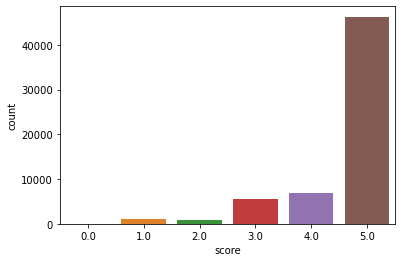

In [60]:
sns.countplot(review['score'])
print(review['score'].value_counts() / len(review['score']))

In [61]:
review['label'] = review['score'].apply(lambda x: 1 if x == 5.0 else 0)
review['label'].value_counts()

1    46295
0    14287
Name: label, dtype: int64

In [62]:
review['label'] = review['label'].apply(lambda x: 'Positive' if x == 1 else 'Negative')

In [63]:
review.head()

,item_id,review_id,login_id,score,content,item_option,date,likeCnt,label
0,24181889,100016281,ross****,5.0,배송빠르고 잘작동합니다. 많이파세요,[옵션]제품선택:소니 DR-BT101,2012-02-24,0,Positive
1,228322167,100019388,hwbs****,5.0,일단 가볍고 간단해서 좋구요.... 저희 신랑이랑 커플로 2개 샀네요.,[옵션]제품선택:아이리버 BT-S10 블루,2012-02-24,0,Positive
2,24181889,100023537,peel**,5.0,배송 빠르고 좋네요~,[옵션]제품선택:소니 DR-BT101,2012-02-24,0,Positive
3,24181889,100028785,moon*****,5.0,만족합니다,[옵션]제품선택:소니 DR-BT101,2012-02-24,0,Positive
4,60614626,100060926,tore****,5.0,만족합니다,[옵션]색상선택:소니 DRC-BT30 블랙,2012-02-25,0,Positive


# 2. 텍스트 전처리

In [160]:
def text_cleaning(reviews):
    clean_review = []
    for review in reviews:
        pattern = "[^ㄱ-ㅎㅏ-ㅣ가-힣 ]"
        temp_review = re.sub(pattern,"",review)
        clean_review.append(temp_review)
    
    return clean_review

def define_stopwords(path):
    SW = set()
    
    with open(path) as f:
        for word in f:
            SW.add(word)
            
    return SW

def text_tokenizing(corpus, tokenizer):
    mecab = Mecab()
    token_corpus = []
    
    if tokenizer == 'noun':
        for n in tqdm_notebook(range(len(corpus)), desc='Preprocessing'):
            token_text = mecab.nouns(corpus[n])
            token_text = [word for word in token_text if word not in SW and len(word) > 1]
            
            token_corpus.append(token_text)
            
    elif tokenizer == 'morph':
        for n in tqdm_notebook(range(len(corpus)),desc='Preprocessing'):
            token_text = mecab.morphs(corpus[n])
            token_text = [word for word in token_text if word not in SW and len(word) > 1]
            token_corpus.append(token_text)
            
    elif tokenizer == "word":
        for n in tqdm_notebook(range(len(corpus)),desc='Preprocessing'):
            token_text = corpus[n].split()
            token_text = [word for word in token_text if word not in SW and len(word) > 1]
            token_corpus.append(token_text)
    
    return token_corpus

content = review['content'].to_list()
SW = define_stopwords('./stopwords.txt')
cleaned_text = text_cleaning(content)
tokenized_text = text_tokenizing(cleaned_text, tokenizer='noun')

In [195]:
a = []
for i in tokenized_text:
    a.append(len(i))

/Users/parkhyunki/opt/anaconda3/envs/test/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [198]:
review['content_length'] = a

/Users/parkhyunki/opt/anaconda3/envs/test/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [162]:
dictionary = corpora.Dictionary(tokenized_text)
corpus = [dictionary.doc2bow(text) for text in tokenized_text]

# 3. 토픽 모델링(LDA)
- 각 단어나 문서의 숨겨진 주제를 찾아내어 문서와 키워드별로 주제끼리 묶어주는 비지도 학습 알고리즘

- 하이퍼 파라미터 : 토픽수, 토픽별 포함단어, alpha, eta
- alpha, eta의 경우 auto 로 설정, 몇번 돌려보고 점수가 높고 해석이 잘되는것으로 선정
- 토픽 수와 토픽별 포함단어는 너무 적거나 너무 많아지면 해석이 어려워지기 때문에 적합한 값을 선정해야함.

In [163]:
NUM_TOPICS = 10
NUM_TOPIC_WORDS = 15

def build_doc_term_mat(documents):
    print('Building document-term matrix.')
    dictionary = corpora.Dictionary(documents)
    corpus = [dictionary.doc2bow(document) for document in documents]
    
    return corpus, dictionary

def print_topic_words(model):
    print('\nPrinting topic words.\n')
    
    for topic_id in range(model.num_topics):
        topic_word_probs = model.show_topic(topic_id, NUM_TOPIC_WORDS)
        print('Topic ID: {}'.format(topic_id))
        
        for topic_word, prob in topic_word_probs:
            print('\t{}\t{}'.format(topic_word, prob))
            
        print('\n')


In [164]:
corpus, dictionary = build_doc_term_mat(tokenized_text)

model = models.ldamodel.LdaModel(corpus, num_topics=NUM_TOPICS, id2word=dictionary, alpha='auto', eta='auto')

Building document-term matrix.


In [165]:
print_topic_words(model)


Printing topic words.

Topic ID: 0
	소리	0.11763501912355423
	번창	0.06223560869693756
	운동	0.060217779129743576
	편리	0.053334251046180725
	나름	0.04401246830821037
	수신	0.041343413293361664
	대박	0.041215214878320694
	내요	0.03650965541601181
	사용	0.034459639340639114
	필요	0.028153996914625168
	패드	0.02775123156607151
	거리	0.02738824672996998
	음질	0.027152620255947113
	상태	0.025193095207214355
	설치	0.023811528459191322


Topic ID: 1
	구입	0.0876377746462822
	선물	0.0853298082947731
	강추	0.04776737838983536
	하나	0.04645129665732384
	구매	0.04098813980817795
	친구	0.03174414113163948
	건데	0.021906042471528053
	확정	0.02005469612777233
	분실	0.01625997945666313
	케이스	0.015524778515100479
	지인	0.01352929137647152
	고급	0.011606195010244846
	교환	0.01120404340326786
	선명	0.011017825454473495
	저음	0.010314698331058025


Topic ID: 2
	시간	0.06594237685203552
	정도	0.040427614003419876
	작동	0.03774692490696907
	버튼	0.037473052740097046
	충전	0.03621821850538254
	조아	0.03531188890337944
	음질	0.025775223970413208
	페어링	0.022171353921294212
	배터리	0

# 4. 평가 및 저장

- 평가기준 
    - perplxity
        - 혼란도, 특정 확률 모델이 실제도 관측되는 값을 얼마나 잘 예측하는가
        - 값이 작으면 토픽모델이 문서를 잘 반영
    - coherence Score
        - 주제의 일관성을 측정
        - 높을수록 토픽의 일관성이 높음

In [166]:
# Compute Perplexity
print('\nPerplexity: ', model.log_perplexity(corpus)) # a measure of how good the model is. lower the better.
 
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=model, texts=tokenized_text, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -6.304759430217982

Coherence Score:  0.5842594236888747


In [133]:
# temp_file = datapath('model')
# model.save(temp_file)

In [147]:
# model = models.ldamodel.LdaModel.load('/Users/parkhyunki/opt/anaconda3/envs/test/lib/python3.7/site-packages/gensim/test/test_data/model')

In [167]:
model.save('./model')

# 5. 시각화

In [168]:
import pyLDAvis
import pyLDAvis.gensim

pyLDAvis.enable_notebook()

data = pyLDAvis.gensim.prepare(model, corpus, dictionary)
data

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
7      0.130187 -0.105147       1        1  19.767156
4      0.205661 -0.074229       2        1  15.519859
3     -0.325473 -0.163699       3        1  11.074535
9     -0.209877 -0.203636       4        1  10.257930
5     -0.156477  0.362707       5        1   9.694126
8      0.018166  0.025090       6        1   7.853164
2      0.181584 -0.060640       7        1   7.851510
6      0.040587  0.064712       8        1   6.812474
1     -0.017225  0.152923       9        1   6.695058
0      0.132868  0.001919      10        1   4.474187, topic_info=    Term         Freq        Total Category  logprob  loglift
0     배송  7961.000000  7961.000000  Default  30.0000  30.0000
192   마음  6056.000000  6056.000000  Default  29.0000  29.0000
14    가격  5637.000000  5637.000000  Default  28.0000  28.0000
73    제품  4683.000000  4683.000000  Default  27.0000  27.0000
5     만족  7302.000000  7302.000000  Default  26.0000  26.0000
..   ...          ...          ...      ...      ...      ...
9     사용   274.680432  5332.645689  Topic10  -3.3680   0.1409
62    음질   216.435622  5521.035294  Topic10  -3.6063  -0.1322
6     구입    97.852073  1483.894476  Topic10  -4.4001   0.3879
99    포장    55.032125   331.761768  Topic10  -4.9757   1.3103
170   하나    58.025802   879.417911  Topic10  -4.9227   0.3885

[510 rows x 6 columns], token_table=      Topic      Freq Term
term                      
14        1  0.001774   가격
14        2  0.000355   가격
14        3  0.000177   가격
14        4  0.997054   가격
14        8  0.000177   가격
...     ...       ...  ...
368       7  0.850926   후회
368       8  0.130434   후회
1885      9  0.989104   흔적
348       4  0.006227   흰색
348       7  0.990105   흰색

[847 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[8, 5, 4, 10, 6, 9, 3, 7, 2, 1])

# 리뷰 별 토픽 매핑
- 분류된 여러 토픽들에 포함된 키워드를 정렬한 뒤, 상위 키워드들의 분포비 등을 확인하여 개별 토픽 정의
    - 각 토픽에 할당된 단어와 단어별 토픽 차지 비율 추출
    - 데이터프레임화
    - 토픽별 추출

In [169]:
def make_topictable_per_doc(ldamodel, corpus):
    topic_table = pd.DataFrame()

    for i, topic_list in enumerate(ldamodel[corpus]):
        doc = topic_list[0] if ldamodel.per_word_topics else topic_list            
        doc = sorted(doc, key=lambda x: (x[1]), reverse=True)

        for j, (topic_num, prop_topic) in enumerate(doc):
            if j == 0: 
                topic_table = topic_table.append(pd.Series([int(topic_num), round(prop_topic,4), topic_list]), ignore_index=True)
            else:
                break
    return (topic_table)

/Users/parkhyunki/opt/anaconda3/envs/test/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [170]:
topictable = make_topictable_per_doc(model, corpus)
topictable = topictable.reset_index()

/Users/parkhyunki/opt/anaconda3/envs/test/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [176]:
topictable

/Users/parkhyunki/opt/anaconda3/envs/test/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,index,0,1,2
0,0,3.0,0.3778,"[(0, 0.023528527), (1, 0.032208532), (2, 0.347..."
1,1,8.0,0.5048,"[(0, 0.017805047), (1, 0.0243887), (2, 0.01964..."
2,2,3.0,0.5571,"[(0, 0.034696434), (1, 0.047496438), (2, 0.038..."
3,3,3.0,0.5571,"[(0, 0.034696445), (1, 0.04749669), (2, 0.0382..."
4,4,3.0,0.5571,"[(0, 0.034696445), (1, 0.04749669), (2, 0.0382..."
...,...,...,...,...
60577,60577,5.0,0.5584,"[(0, 0.034696434), (1, 0.047496438), (2, 0.038..."
60578,60578,7.0,0.5587,"[(3, 0.016432), (5, 0.10977812), (7, 0.5586643..."
60579,60579,1.0,0.5095,"[(0, 0.017799493), (1, 0.50949085), (2, 0.0196..."
60580,60580,5.0,0.1595,"[(0, 0.066045694), (1, 0.09041088), (2, 0.0728..."


In [177]:
review

/Users/parkhyunki/opt/anaconda3/envs/test/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,item_id,review_id,login_id,score,content,item_option,date,likeCnt,label
0,24181889,100016281,ross****,5.0,배송빠르고 잘작동합니다. 많이파세요,[옵션]제품선택:소니 DR-BT101,2012-02-24,0,Positive
1,228322167,100019388,hwbs****,5.0,일단 가볍고 간단해서 좋구요.... 저희 신랑이랑 커플로 2개 샀네요.,[옵션]제품선택:아이리버 BT-S10 블루,2012-02-24,0,Positive
2,24181889,100023537,peel**,5.0,배송 빠르고 좋네요~,[옵션]제품선택:소니 DR-BT101,2012-02-24,0,Positive
3,24181889,100028785,moon*****,5.0,만족합니다,[옵션]제품선택:소니 DR-BT101,2012-02-24,0,Positive
4,60614626,100060926,tore****,5.0,만족합니다,[옵션]색상선택:소니 DRC-BT30 블랙,2012-02-25,0,Positive
...,...,...,...,...,...,...,...,...,...
60577,32688199,99982065,dolb****,5.0,무척 마음에 듭니다.,,2012-02-24,0,Positive
60578,32688199,99982229,dolb****,5.0,역시 자브라 입니다. 디자인과 품질 전부 만족합니다. 무엇보다 역시 디자인 크래들에...,,2012-02-24,0,Positive
60579,60614626,99983950,ccom*****,5.0,신랑이 너무 좋아하네요 저도 하나 구입해야 할까뵈요,[옵션]색상선택:소니 DRC-BT30 블랙,2012-02-24,0,Positive
60580,228322167,99989740,ace9***,5.0,좋습니다!!,[옵션]제품선택:아이리버 BT-S10 핑크,2012-02-24,0,Positive


In [184]:
review['topic'] = topictable[0]

/Users/parkhyunki/opt/anaconda3/envs/test/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [185]:
review.head(10)

/Users/parkhyunki/opt/anaconda3/envs/test/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,item_id,review_id,login_id,score,content,item_option,date,likeCnt,label,topic
0,24181889,100016281,ross****,5.0,배송빠르고 잘작동합니다. 많이파세요,[옵션]제품선택:소니 DR-BT101,2012-02-24,0,Positive,3.0
1,228322167,100019388,hwbs****,5.0,일단 가볍고 간단해서 좋구요.... 저희 신랑이랑 커플로 2개 샀네요.,[옵션]제품선택:아이리버 BT-S10 블루,2012-02-24,0,Positive,8.0
2,24181889,100023537,peel**,5.0,배송 빠르고 좋네요~,[옵션]제품선택:소니 DR-BT101,2012-02-24,0,Positive,3.0
3,24181889,100028785,moon*****,5.0,만족합니다,[옵션]제품선택:소니 DR-BT101,2012-02-24,0,Positive,3.0
4,60614626,100060926,tore****,5.0,만족합니다,[옵션]색상선택:소니 DRC-BT30 블랙,2012-02-25,0,Positive,3.0
5,164042308,100062275,wooz***,5.0,굿입니다.,[옵션]제품선택:자브라 EASYGO,2012-02-25,0,Positive,5.0
6,164042308,100062307,wooz***,5.0,굿입니다. 굿입니다.굿입니다.굿입니다.굿입니다.굿입니다.굿입니다.굿입니다.굿입니다....,[옵션]제품선택:자브라 EASYGO,2012-02-25,0,Positive,5.0
7,228322167,100062938,tjdc***,5.0,좋음~~~~괜츈`~~~,[옵션]제품선택:아이리버 BT-S10 블루,2012-02-25,0,Positive,5.0
8,60614626,100063193,mylo******,5.0,좋아여 ㅋ,[옵션]색상선택:소니 DRC-BT30 블랙,2012-02-25,0,Positive,5.0
9,60614626,100063222,mylo******,5.0,블랙 구입했는데 완전 만족합니다. ㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋ...,[옵션]색상선택:소니 DRC-BT30 블랙,2012-02-25,0,Positive,3.0


In [186]:
review['topic'] = review['topic'].astype(int)

/Users/parkhyunki/opt/anaconda3/envs/test/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [187]:
def topic_mapping(x):
    if x == 0:
        return 'Sound Quality'
    elif x == 1:
        return 'Satisfaction'
    elif x == 2:
        return 'Battery'
    elif x == 3:
        return 'Delivery'
    elif x == 4:
        return 'Sound Quality'
    elif x == 5:
        return 'Satisfaction'
    elif x == 6:
        return 'Pairing'
    elif x == 7:
        return 'Sound Quality'
    elif x == 8:
        return 'Bluetooth'
    elif x == 9:
        return 'Price'
    
review['topic'] = review['topic'].apply(topic_mapping)

/Users/parkhyunki/opt/anaconda3/envs/test/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [188]:
review['topic'].value_counts()

/Users/parkhyunki/opt/anaconda3/envs/test/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Satisfaction     32796
Sound Quality    10689
Delivery          9164
Price             4509
Battery           1577
Pairing            966
Bluetooth          881
Name: topic, dtype: int64

In [189]:
review['score'] = review['score'].astype(int)

/Users/parkhyunki/opt/anaconda3/envs/test/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [190]:
review.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60582 entries, 0 to 60581
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   item_id      60582 non-null  object
 1   review_id    60582 non-null  object
 2   login_id     60582 non-null  object
 3   score        60582 non-null  int64 
 4   content      60582 non-null  object
 5   item_option  60582 non-null  object
 6   date         60582 non-null  object
 7   likeCnt      60582 non-null  int64 
 8   label        60582 non-null  object
 9   topic        60582 non-null  object
dtypes: int64(2), object(8)
memory usage: 4.6+ MB


/Users/parkhyunki/opt/anaconda3/envs/test/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [191]:
review.to_csv('./venv/topic_review.csv',index=False,sep='|',encoding='utf-8')

/Users/parkhyunki/opt/anaconda3/envs/test/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [192]:
data= pd.read_csv('./venv/review_topic.csv',sep='|')

/Users/parkhyunki/opt/anaconda3/envs/test/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [193]:
data.head()

/Users/parkhyunki/opt/anaconda3/envs/test/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,item_id,review_id,login_id,score,content,item_option,date,likeCnt,topic,label
0,24181889,100016281,ross****,5,배송빠르고 잘작동합니다. 많이파세요,[옵션]제품선택:소니 DR-BT101,2012-02-24,0,Delivery,Positive
1,24181889,100023537,peel**,5,배송 빠르고 좋네요~,[옵션]제품선택:소니 DR-BT101,2012-02-24,0,Delivery,Positive
2,24181889,100028785,moon*****,5,만족합니다,[옵션]제품선택:소니 DR-BT101,2012-02-24,0,Sound quality,Positive
3,60614626,100060926,tore****,5,만족합니다,[옵션]색상선택:소니 DRC-BT30 블랙,2012-02-25,0,Sound quality,Positive
4,164042308,100062275,wooz***,5,굿입니다.,[옵션]제품선택:자브라 EASYGO,2012-02-25,0,Satisfaction,Positive
